# Utilizing Risk Factor Scores in Audit Data to Distinguish ‘Risky’ and ‘Not Risky’ Businesses

## 1. Introduction

Auditing is the process of investigating the financial records of businesses to ensure that they comply with internationally-accepted legal standards. In this project, the dataset used is the 'Audit Data' collected by the Comptroller and Auditor General (CAG) in India between 2015-2016. This data focuses on 777 firms from 46 cities that were grouped into 14 different sectors. The CAG investigated risk factors relevant to assisting auditors in accurately identifying businesses that pose a risk of committing unfair practices (N. Hooda et al., 2018). Our project revolves around applying predictive analytics in the classification of fraudulent firms using the case study above. Therefore, we will attempt to tackle the research question: Is a business risky of committing fraud based on its inherent, control, and detection risk scores?

The product of discrepancies that may occur during company transactions (Inherent risk), internal audit (Control risk), and external audit (Detection risk) gives us the audit risk score (ARS). In the risk assessment, the companies with ARS scores greater or equal to 1 are identified as ‘risky’ firms and are assigned a risk assessment value of 1, and companies scoring less than 1 are classified as ‘not risky’ firms, getting a risk assessment score of 0.

Potential limitations include manipulation/incorrect logging of companies’ transactions at the internal audit stage to obtain lower control risk scores, and exclusion of other possible relevant factors that can influence the prediction.

## 2. Methods and Results

In [1]:
#load library
options(repr.matrix.max.rows=8)
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Read dataset and correct variable types
audit_data <- read_csv("data/audit_risk.csv") |>
    mutate(Risk = as.factor(Risk)) |>
    mutate(LOCATION_ID = as.integer(LOCATION_ID)) 

#Splitting data into training set and testing set
set.seed(265)
audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

#Printing training data set
audit_training

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0
3.89,8,3.98,0.6,2.388,0.99,0.2,0.198,4.97,5,⋯,0.4,0,0.2,0,2.4,4.372,0.4,0.5,0.8744,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,2,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,1.2,0,0.2,0,2.4,2.200,1.2,0.5,1.3200,1
55.57,2,1.06,0.4,0.424,0.63,0.2,0.126,1.69,5,⋯,1.2,0,0.2,0,2.6,2.930,1.2,0.5,1.7580,1
55.57,32,0.00,0.2,0.000,8.49,0.6,5.094,8.49,5,⋯,0.4,0,0.2,0,3.2,6.580,0.4,0.5,1.3160,1
55.57,13,1.06,0.4,0.424,1.60,0.4,0.640,2.66,5,⋯,0.4,0,0.2,0,3.2,12.118,0.4,0.5,2.4236,1


In [3]:
#Cleaning audit data for the original raw variables
audit_data_raw <- audit_data |>
    select(-Score_B...7, -Score_B...11) |>
    filter(Money_Value != "") |> 
    select(PARA_A:Score, Audit_Risk, Risk)

audit_split_raw <- initial_split(audit_data_raw, prop = 0.75, strata = Risk) 
audit_training_raw <- training(audit_split_raw)
audit_testing_raw <- testing(audit_split_raw)

#Printing training data set
audit_training_raw

PARA_A,Score_A,Risk_A,PARA_B,Risk_B,TOTAL,numbers,Risk_C,Money_Value,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,Audit_Risk,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.2,0.000,4.83,0.966,4.83,5,1,0.94,0.2,0.188,2,0.2,0.4,0,0.2,0,2,0.5108,0
0.51,0.2,0.102,0.23,0.046,0.74,5,1,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0,2,0.3096,0
0.00,0.2,0.000,0.08,0.016,0.08,5,1,0.00,0.2,0.000,2,0.2,0.4,0,0.2,0,2,0.2832,0
0.00,0.2,0.000,0.83,0.166,0.83,5,1,2.95,0.2,0.590,2,0.2,0.4,0,0.2,0,2,0.4312,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.00,0.2,0.000,0.00,0.000,0.00,5,1,0.00,0.2,0.000,6,0.2,1.2,0,0.2,0,2.4,1.3200,1
1.06,0.4,0.424,0.63,0.126,1.69,5,1,0.90,0.2,0.180,6,0.2,1.2,0,0.2,0,2.6,1.7580,1
0.00,0.2,0.000,8.49,5.094,8.49,5,1,0.43,0.2,0.086,2,0.2,0.4,0,0.2,0,3.2,1.3160,1
1.06,0.4,0.424,1.60,0.640,2.66,5,1,16.09,0.6,9.654,2,0.2,0.4,0,0.2,0,3.2,2.4236,1


### Summary of Dataset

In [4]:
#Table reporting number of sectors and number of firms under each sector
firm_count <- audit_training |>
    select(LOCATION_ID) |>
group_by(LOCATION_ID) |>
    summarise(firm_count = n())
print(firm_count)

# A tibble: 42 × 2
   LOCATION_ID firm_count
         <int>      <int>
 1           1          9
 2           2         33
 3           3          3
 4           4         27
 5           5         35
 6           6         27
 7           7          4
 8           8         58
 9           9         42
10          11         18
# … with 32 more rows


The number of firms under each sector is counted using sector-unique historical risk scores (Sector_Score). The table shows 13 different sectors and the brief count of firms under each of them. Nonetheless, using Sector_Score may not produce the most accurate count as some sectors could have equal historical risk scores.

In [5]:
#Creating summary table of relevant variables
average_risk_factors <- audit_training |> 
    select(Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk) |> 
    map_dfc(mean, na.rm = TRUE)
average_risk_factors

Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk
<dbl>,<dbl>,<dbl>,<dbl>
17.66497,0.5772806,0.5,6.275287


The average Audit Risk Score is 6.27, which is more than the benchmark 1 (according to the clear depiction in the plots below). This summary table alone could signify that most of the nominated businesses will likely be classified as risky. However, we have to remember that the average value could be skewed by extreme outliers.

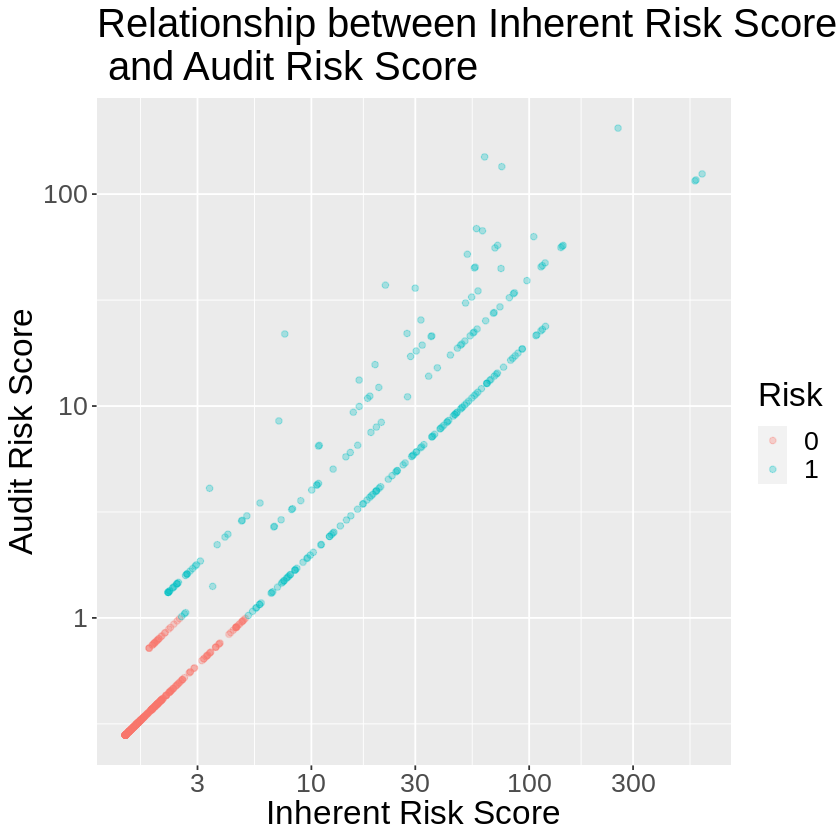

In [6]:
#Setting up plot size
options(repr.plot.width = 7, repr.plot.height = 7)

IR_AR_plot <- audit_training |>
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Inherent Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Inherent Risk Score \n and Audit Risk Score') +
    theme(text = element_text(size =20))
IR_AR_plot

We see a strong positive linear relationship between Audit Risk Score and Inherent Risk Score. It also seems that the 'not risky' companies are clustered below an Audit Risk score of 1 whereas the ‘risky’ firms are spread out above an Audit Risk score of 1.

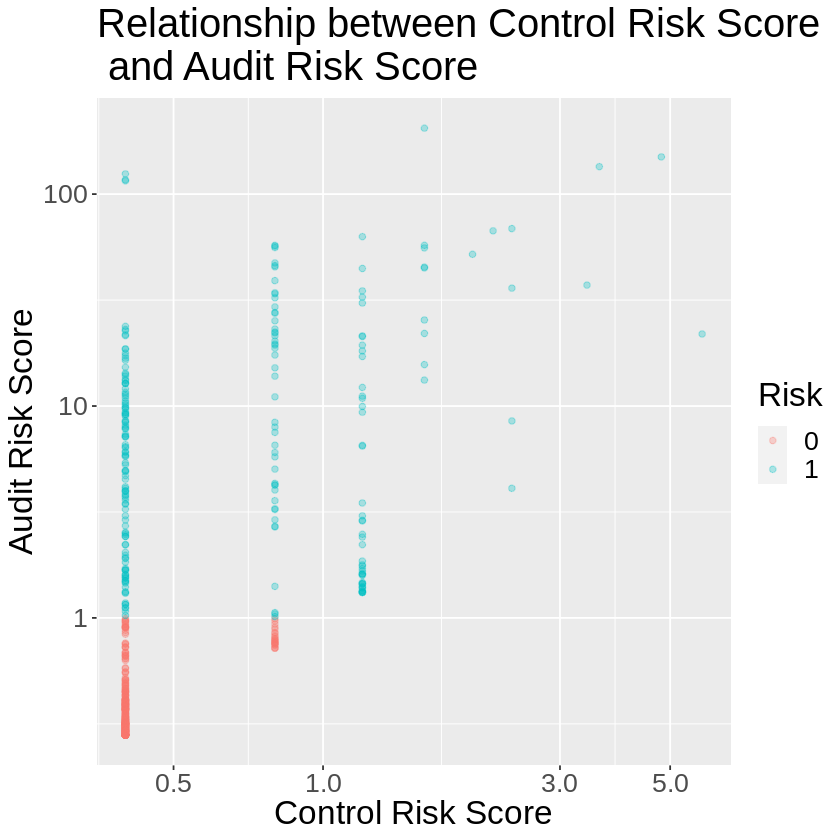

In [7]:
CR_AR_plot <- audit_training |>
    ggplot(aes(x = CONTROL_RISK, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Control Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Control Risk Score \n and Audit Risk Score') +
    theme(text = element_text(size =20))
CR_AR_plot

The ‘not risky’ companies have a constant Control Risk Score of approximately 0.2 or 0.8. In contrast, the ‘risky’ companies show some variation, with Control Risk scores going above 1. However, a good amount of observations are also found at 0.2 and 0.8. Overall, the Control Risk Score and Audit Risk Score have a linear and slightly positive relationship with a few outliers among ‘risky’ companies.

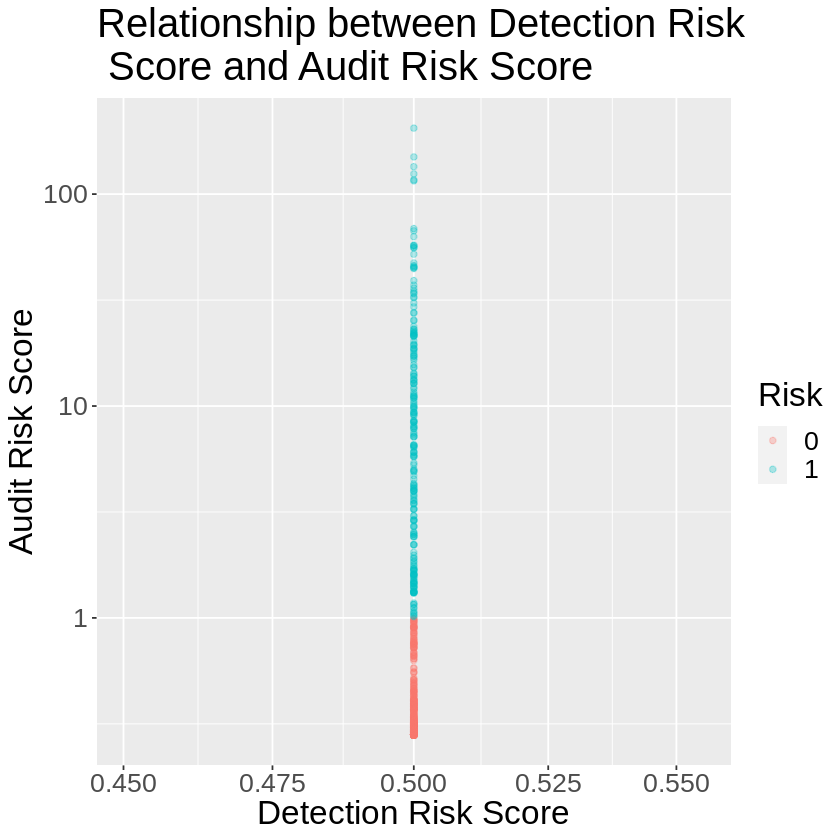

In [8]:
DR_AR_plot <- audit_training |>
    ggplot(aes(x = Detection_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 0.3)+
    labs(x = "Detection Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Detection Risk \n Score and Audit Risk Score') +
    theme(text = element_text(size =20))
DR_AR_plot

Since the Detection Risk is constant at 0.5 throughout the dataset, it has no relationship with the Audit Risk Score.

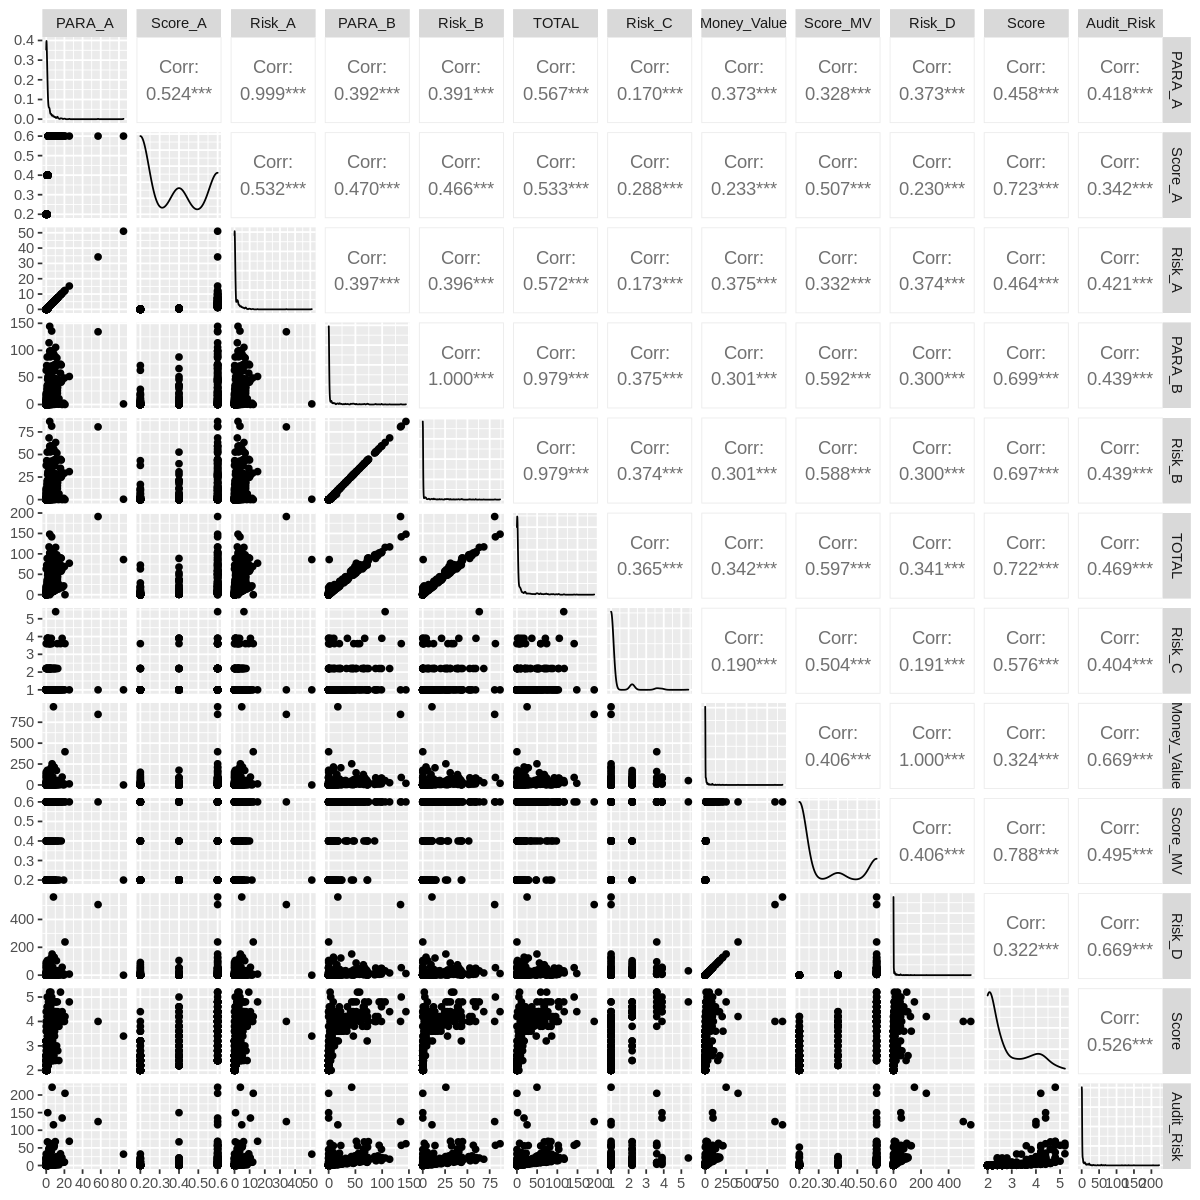

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10)

tgt_plot <- audit_training_raw |>
    select(-numbers, -District_Loss, -PROB, -RiSk_E, -History, -Prob, -Risk_F, -Risk) |>
    ggpairs()
tgt_plot

We're visualizing Money Value cuz it has the highest correlation

Warning message:
“Transformation introduced infinite values in continuous x-axis”


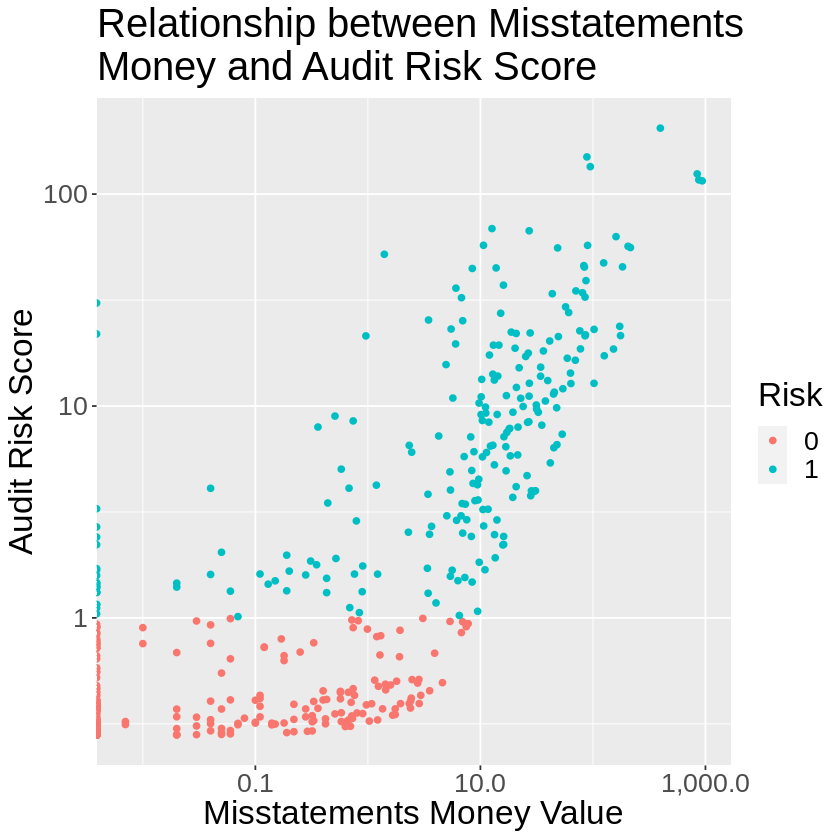

In [17]:
options(repr.plot.width = 7, repr.plot.height = 7)

Money_AR_plot <- audit_training |>
    ggplot(aes(x = Money_Value, y = Audit_Risk))+
    geom_point(aes(colour = Risk), alpha = 1)+
    labs(x = "Misstatements Money Value", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    ggtitle('Relationship between Misstatements \nMoney and Audit Risk Score') +
    theme(text = element_text(size =20))
Money_AR_plot

Describe breifly the trend of Money Value and state how its not linear as the previous pre-calculated variables graphs anymore

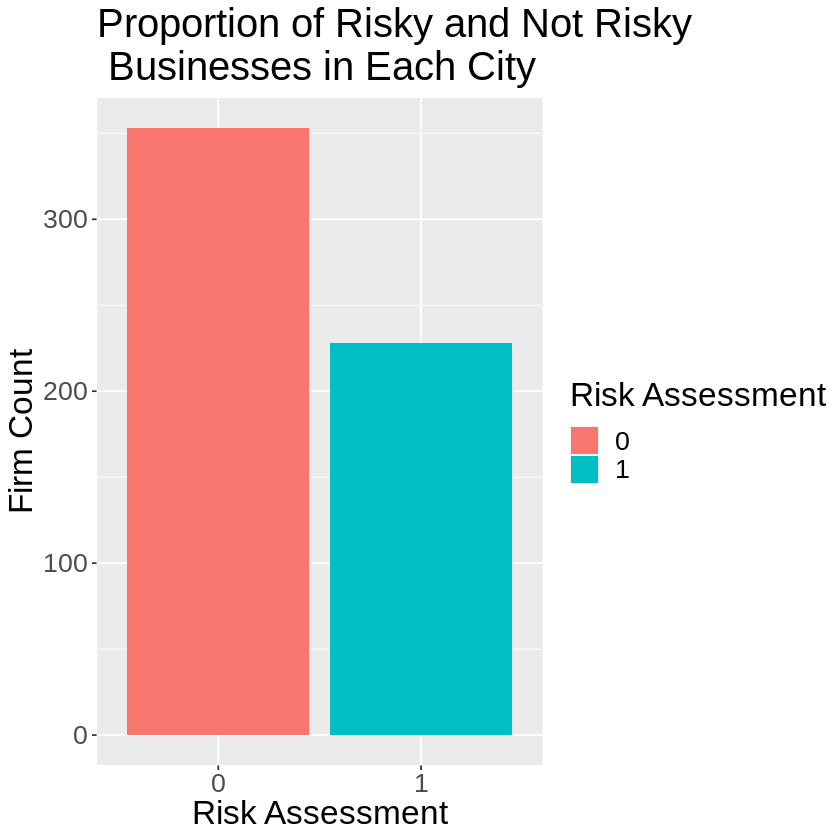

In [18]:
#Visualize Risky and Not Risky proportion in the training data set
Risk_proportion <- audit_training |>
    ggplot(aes(x = Risk, fill=Risk)) +
    geom_bar() +
    labs(x = 'Risk Assessment', y = 'Firm Count', fill = 'Risk Assessment') +
    theme(text = element_text(size = 20)) +
    ggtitle('Proportion of Risky and Not Risky \n Businesses in Each City')
Risk_proportion

In [12]:
#Calculate proportion percentage for each class
proportion <- tibble(Not_Risky = 353/(353+228)*100, Risky = 228/(353+228)*100)
proportion

Not_Risky,Risky
<dbl>,<dbl>
60.75731,39.24269


### The proportion of Risky and Not Risky businesses in the training dataset is 60% vs 40%. This is not a drastic difference, hence our prediction will not lean more towards one class than the other. EDIT LATER TALK ABOUT MAJORITY CLASSIF

### Data Analysis

We will conduct our data analysis using the K-Nearest Neighbours (K-NN) classification model to predict the Risk classification of a business.

The predictor variables we will use are Inherent_Risk and Control_Risk as they take majority of the variables in the dataset into account. Although the Audit Risk score (ARS) includes the aforementioned risk factors as well as the Detection_Risk, the Detection Risk score has a constant value of 0.5 throughout the dataset. Hence, it will not be included in our model as it does not influence the ARS.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9948421,5,0.003426357,Preprocessor1_Model01
2,accuracy,binary,0.9948421,5,0.003426357,Preprocessor1_Model02


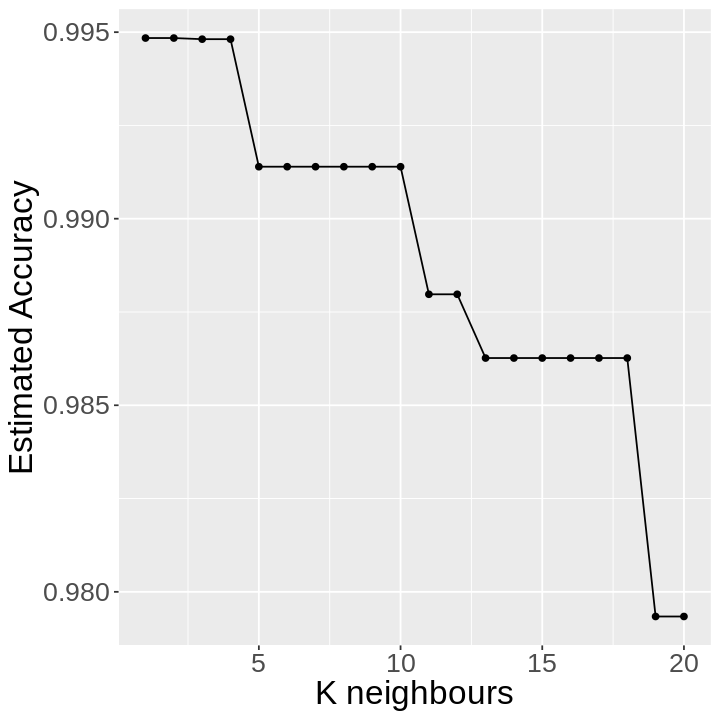

In [13]:
#Setting Randomization seed
set.seed(4384)

#Setting plot size
options(repr.plot.width = 6, repr.plot.height = 6)

#Stil debating which predictor variables to use
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

kvals <- tibble(neighbors = seq(from = 1, to = 20, by =1))

v_fold <- vfold_cv(audit_training, v = 5, strata = Risk)

audit_recipe <- recipe(Risk ~ Inherent_Risk + CONTROL_RISK, data = audit_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_finding <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = v_fold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == 'accuracy')
    
k_finding_result <- k_finding |>
    filter(mean == max(mean))
k_finding_result

k_finding_plot <- ggplot(k_finding, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = 'K neighbours', y = 'Estimated Accuracy')+
    theme(text = element_text(size = 20))
k_finding_plot

Here we set up the code for finding the best k blabla and here our k is 5. next we are going to perform the final prediction again using out best k 

In [14]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

audit_best_fit <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = audit_training)

audit_predict <- predict(audit_best_fit, audit_testing) |>
    bind_cols(audit_testing) |>
    select(.pred_class, Risk)

audit_prediction_accuracy <- audit_predict |>
    metrics(truth = Risk , estimate = .pred_class)
audit_prediction_accuracy

New names:
• `Score_B...7` -> `Score_B...8`
• `Score_B...11` -> `Score_B...12`


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,1
kap,binary,1


THERE IS A 100% ACCURACY USING PRE-CALCULATED VARIABLES SO WE WILL CHANGE OUR MODEL TO USE MORE RAW DATA INSTEAD

#### Data Analysis Using Raw Data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9793385,5,0.003438619,Preprocessor1_Model01
2,accuracy,binary,0.9793385,5,0.003438619,Preprocessor1_Model02


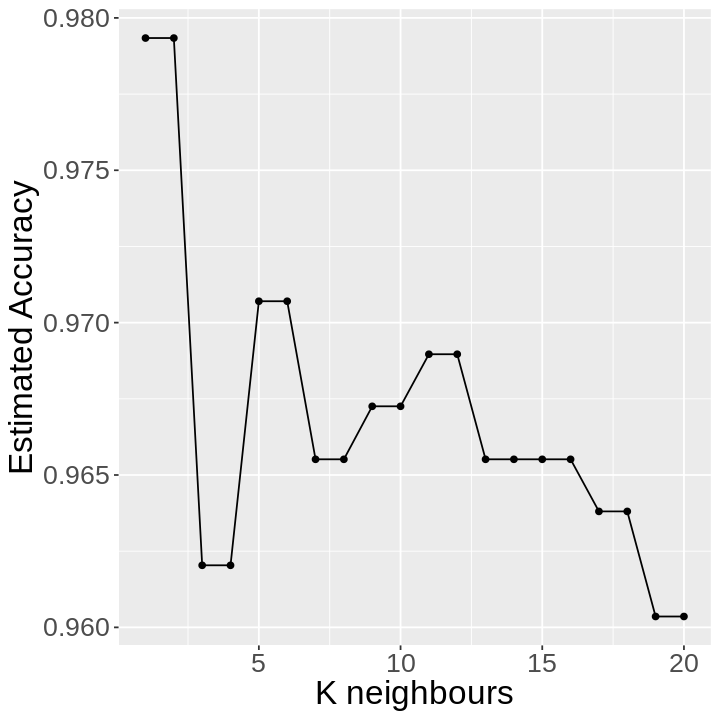

In [15]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

kvals_2 <- tibble(neighbors = seq(from = 1, to = 20, by =1))

v_fold_2 <- vfold_cv(audit_training, v = 5, strata = Risk)

audit_recipe_2 <- recipe(Risk ~ . ,data = audit_training_raw) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_finding_2 <- workflow() |>
    add_recipe(audit_recipe_2) |>
    add_model(knn_spec_2) |>
    tune_grid(resamples = v_fold_2, grid = kvals_2) |>
    collect_metrics() |>
    filter(.metric == 'accuracy')
    
k_finding_result_2 <- k_finding_2 |>
    filter(mean == max(mean))
k_finding_result_2

k_finding_plot_2 <- ggplot(k_finding_2, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = 'K neighbours', y = 'Estimated Accuracy')+
    theme(text = element_text(size = 20))
k_finding_plot_2

After tuning again, the best k is still 2 

In [16]:
knn_spec_raw <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

audit_recipe_raw <- recipe(Risk ~ ., data = audit_training_raw) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

audit_fit_raw <- workflow() |>
    add_recipe(audit_recipe_raw) |>
    add_model(knn_spec_raw) |>
    fit(data = audit_training_raw)

audit_predict_raw <- predict(audit_fit_raw, audit_testing_raw) |>
    bind_cols(audit_testing_raw)

audit_prediction_accuracy_raw <- audit_predict_raw |>
    metrics(truth = Risk , estimate = .pred_class)
audit_prediction_accuracy_raw

conf_mat_raw <- audit_predict_raw |>
    conf_mat(truth = Risk, estimate = .pred_class)
conf_mat_raw

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9794872
kap,binary,0.9572696


          Truth
Prediction   0   1
         0 115   1
         1   3  76

Using the raw variables, we get a 97.9% accuracy instead. The confusion matrix shows a total of 4 miss-predictions.

## 3. Discussion

With 97.9% accuracy, this is a great improvement from the majority classification with the 60% accuracy.  

### Future Questions

While these findings can help improve auditing practices for future investigations, it also raises the question of how we can ensure that the targetted businesses’ financial statements were not manipulated. Additionally, is there any way we can reduce the number of companies that commit fraud? Furthermore, what are the leading causes of companies having high Audit Risk scores in the first place?